In [37]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'Datasets/creditcard.csv'
data = pd.read_csv(file_path)

# Separate features and target
X = data.drop('Class', axis=1).values
y = data['Class'].values

# Scaling the 'Time' and 'Amount' features
scaler = StandardScaler()
X[:, [0, -1]] = scaler.fit_transform(X[:, [0, -1]])  # Assuming 'Time' is the first and 'Amount' is the last feature in the DataFrame

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create TensorDatasets for both training and testing data
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
test_dataset = TensorDataset(X_test, y_test.unsqueeze(1))

# Create DataLoaders for both datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)


In [38]:
if False:
    # Display a concise summary of the dataframe
    print("\nDataset Info:")
    data.info()

    # Display statistical summary of numerical features
    print("\nStatistical Summary of Numerical Features:")
    print(data.describe())

    # Check for missing values
    print("\nMissing Values in the Dataset:")
    print(data.isnull().sum())

    # Check the balance of the classes
    print("\nClass Distribution:")
    print(data['Class'].value_counts(normalize=True))


In [39]:
if False:
    # Distribution of Transaction Amount
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Amount'], bins=100, kde=True)
    plt.title('Distribution of Transaction Amount')
    plt.xlim([0, max(data['Amount'])])
    plt.show()

    # Distribution of Transaction Time
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Time'], bins=100, kde=True)
    plt.title('Distribution of Transaction Time')
    plt.xlim([0, max(data['Time'])])
    plt.show()

    # Class Distribution (Fraud vs. Non-Fraud)
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Class', data=data)
    plt.title('Class Distribution (0: No Fraud, 1: Fraud)')
    plt.show()

In [40]:
if False:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='V1', y='V2', hue='Class', data=data, alpha=0.5)
    plt.title('Scatter plot of the first two PCA components')
    plt.show()

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import logging
import os
%load_ext line_profiler
try:
    profile
except NameError:
    def profile(func): 
        return func

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [42]:

class Clustering:
    def __init__(self, parent):
        self.parent = parent # Reference to the parent class
        self.feature_dim = parent.feature_dim # Number of features in the dataset
        self.Gamma_max = torch.exp(-torch.tensor(parent.num_sigma, dtype=torch.float32, device=self.parent.device)**2) # Maximum value of Gamma (used to determine if a new cluster should be added)
    
    @profile             
    def _add_new_cluster(self, z, label):
        ''' Adds a new cluster to the model. This is called when no matching clusters are found or when the Gamma value is too low.'''
        
        self._update_S_0(z) # Update S_0 based on the new sample

        # Expand the capacity of the model if necessary
        if self.parent.c >= self.parent.current_capacity:
            self.parent.overseer.expand_capacity()

        # Add the new cluster
        cluster_index = self.parent.c # Index of the new cluster 

        # Clone the parameters and perform updates
        new_mu = self.parent.mu.data.clone()
        new_S = self.parent.S.data.clone()
        new_n = self.parent.n.data.clone()

        # Perform the updates
        new_mu[cluster_index] = z.clone()
        new_S[cluster_index] = self.parent.S_0.clone()
        new_n[cluster_index] = 1.0

        # Reassign the updated values as Parameters
        self.parent.mu = torch.nn.Parameter(new_mu, requires_grad=True)
        self.parent.S = torch.nn.Parameter(new_S, requires_grad=True)
        self.parent.n = torch.nn.Parameter(new_n, requires_grad=True)

        # Update cluster_labels
        # If cluster_labels is not a Parameter and does not require gradients, update as a regular tensor
        self.parent.cluster_labels[cluster_index] = label

        self.parent.c += 1 # Increment the number of clusters

        # Add the new cluster to the list of matching clusters for the label of the sample (if it doesn't already exist) 
        if label not in self.parent.label_to_clusters:
            self.parent.label_to_clusters[label.item()] = torch.empty(0, dtype=torch.int32, device=self.parent.device)
        
        # Add the new cluster to the list of matching clusters
        self.parent.label_to_clusters[label.item()] = torch.cat((self.parent.label_to_clusters[label.item()], torch.tensor([self.parent.c - 1], dtype=torch.int32, device=self.parent.device)))
    
        #Add a new Gamma value for the new cluster equal to 1 (Gamma is the weight of the cluster) 
        self.parent.Gamma = torch.cat((self.parent.Gamma, torch.tensor([1.0], dtype=torch.float32, device=self.parent.device)))
        
        return
    
    @profile 
    def _update_S_0(self, sample):
        sample = sample.squeeze()  # Reducing to 1D if necessary

        # Initialize max, min if they do not exist
        if not hasattr(self, 'max_values'):
            self.max_values = sample.clone()
        if not hasattr(self, 'min_values'):
            self.min_values = sample.clone()

        # Update max and min values
        for i, feature in enumerate(sample):
            if feature > self.max_values[i]:
                self.max_values[i] = feature
            elif feature < self.min_values[i]:
                self.min_values[i] = feature

        # Ensure all tensors are on the same device
        self.max_values = self.max_values.to(self.parent.device)
        self.min_values = self.min_values.to(self.parent.device)

        # Calculate the number of unique values in self.parent.mu for each dimension
           # Calculate the number of unique values in self.parent.mu for each dimension
        if len(self.parent.mu) > 0:
            # Extract all mu values into a single tensor
            all_mu = torch.stack([mu for mu in self.parent.mu], dim=0)
            unique_counts = torch.tensor([torch.unique(all_mu[:, i]).numel() for i in range(all_mu.size(1))], device=self.parent.device)
        else:
            # If self.parent.mu is empty, assume a default unique count for each feature
            # This can be 1 or any other default value you choose
            unique_counts = torch.ones(sample.size(0), device=self.parent.device)

        # Calculate ΔS_0 for each feature using the number of unique values
        #delta_S_0 = (self.max_values - self.min_values) / (2*(2**(1/self.feature_dim) + 1))
        delta_S_0 = (self.max_values - self.min_values) / (2*self.parent.c_max)

        #self.parent.S_0 = self.parent.S_0  + (torch.diag(delta_S_0)-self.parent.S_0)
        self.parent.S_0 = torch.diag(delta_S_0**2)
        self.parent.S_0 = torch.max(self.parent.S_0, self.parent.S_0_initial)

        # Now check each cluster and update S where n equals 1
        #for j, cluster_n in enumerate(self.parent.n):
        #    if cluster_n.item() == 1:  # .item() to get the Python scalar from the tensor
                # Replace the covariance matrix for clusters where n equals 1
        #        self.parent.S[j] = torch.nn.Parameter(self.parent.S_0, requires_grad=True)
                # Update the inverse of the covariance matrix as well
                #self.parent.math_ops._update_inverse_covariance(j)
    

    @profile      
    def _increment_cluster(self, z, j, label):
        
        if self.parent.enable_debugging and (j >= len(self.parent.mu) or j < 0):
            logging.warning(f"Warning rule increment! Invalid cluster index: {j}. Valid indices are between 0 and {len(self.parent.mu)-1}.")
        
        
        e = z - self.parent.mu[j] # Error between the sample and the cluster mean
        self.parent.mu[j] += 1 / (1 + self.parent.n[j]) * e
        self.parent.S[j] += e.view(-1, 1) @ (z - self.parent.mu[j]).view(1, -1)
        self.parent.n[j] += 1
        #self.parent.S_inv[j] = self.parent.math_ops._compute_covariance_inverse(self.parent.S[j])
        '''
        
        e = z - self.parent.mu[self.parent.matching_clusters]# Error between the sample and the cluster mean
        scaling_factors = self.parent.Gamma[self.parent.matching_clusters]

        self.parent.mu[self.parent.matching_clusters] += (scaling_factors / (1 + self.parent.n[self.parent.matching_clusters])).unsqueeze(1) * e

        # Compute the scaled difference
        scaled_diff = scaling_factors.view(-1, 1, 1) * (z - self.parent.mu[self.parent.matching_clusters]).view(-1, 1, 2) 

        # Perform the outer product and update self.parent.S
        self.parent.S[self.parent.matching_clusters] += e.view(-1, 2, 1)  @ scaled_diff  # Resulting shape: [6, 2, 2]

        self.parent.n[self.parent.matching_clusters] += scaling_factors
        '''

        return
    
    @profile      
    def increment_or_add_cluster(self, z, label):

        if len(self.parent.matching_clusters) == 0:
            self._add_new_cluster(z, label)
            #self.parent.num_labels = len(self.parent.label_to_clusters)
            logging.info(f"Info. Added new cluster for label {label} due to no matching clusters. Total clusters now: {self.parent.c}")
            return torch.tensor([1.0], device=self.parent.device)
        
        #matching_clusters_tensor = torch.tensor([i for i, cluster_label in enumerate(self.parent.cluster_labels) if label == cluster_label], device=self.parent.device)

        #matching_values = torch.tensor([self.parent.Gamma[i] for i in self.parent.matching_clusters], dtype=torch.float32, device=self.parent.device)
        _, j_rel = torch.max(self.parent.Gamma[self.parent.matching_clusters], dim=0)
        j_abs = self.parent.matching_clusters[j_rel].item()  # Map relative index back to full list of clusters
        
        if self.parent.enable_adding and (self.parent.Gamma[j_abs] <= self.Gamma_max):
            self._add_new_cluster(z, label)
            #logging.info(f"Info. Added new cluster for label {label} due to low Gamma value. Total clusters now: {self.parent.c}")
        else:
            self._increment_cluster(z, j_abs, label)

        return



In [43]:
class RemovalMechanism:
    def __init__(self, parent):
        self.parent = parent

    def remove_cluster(self, cluster_index):
        last_active_index = self.parent.c - 1

        if cluster_index != last_active_index:
            # Store the original label of the cluster that is being removed
            removed_cluster_label = self.parent.cluster_labels[cluster_index].item()

            # Move the last active cluster to the position of the cluster to be removed
            self.parent.mu[cluster_index] = self.parent.mu[last_active_index]
            self.parent.S[cluster_index] = self.parent.S[last_active_index]
            self.parent.n[cluster_index] = self.parent.n[last_active_index]
            
            # Update the label of the cluster that is moved
            moved_cluster_label = self.parent.cluster_labels[last_active_index].item()
            self.parent.cluster_labels[cluster_index] = self.parent.cluster_labels[last_active_index]

            # Update label_to_clusters for the removed cluster
            self.parent.label_to_clusters[removed_cluster_label] = self.parent.label_to_clusters[removed_cluster_label][self.parent.label_to_clusters[removed_cluster_label] != cluster_index]

            # If the labels of the moved and removed clusters are different, update the dictionary entries
            if moved_cluster_label != removed_cluster_label:
                # Remove the last active index from its original label entry
                self.parent.label_to_clusters[moved_cluster_label] = self.parent.label_to_clusters[moved_cluster_label][self.parent.label_to_clusters[moved_cluster_label] != last_active_index]
                # Add the moved cluster index (now at cluster_index) to the new label entry
                self.parent.label_to_clusters[removed_cluster_label] = torch.cat((self.parent.label_to_clusters[removed_cluster_label], torch.tensor([cluster_index], dtype=torch.int32, device=self.parent.device)))

            # Remove the cluster from the matching_clusters list
            self.parent.matching_clusters = self.parent.matching_clusters[self.parent.matching_clusters != cluster_index]

            # Update the Gamma value for the cluster 
            self.parent.Gamma[cluster_index] = self.parent.Gamma[last_active_index]

        # Decrement the count of active clusters
        self.parent.c -= 1


In [44]:
class MergingMechanism:
    def __init__(self, parent):
        self.parent = parent
        self.feature_dim = parent.feature_dim
        self.V_factor = (2 * torch.pi ** (self.feature_dim/2) / 
                        (self.feature_dim * torch.exp(torch.lgamma(torch.tensor(float(self.feature_dim) / 2, device=self.parent.device)))))
        
    @profile      
    def perform_merge(self, kappa, kappa_min):
        # Find the indices with the minimum kappa value
        i_valid, j_valid = (kappa == kappa_min).nonzero(as_tuple=True)
        i_valid, j_valid = i_valid[0].item(), j_valid[0].item()  # Convert tensor indices to integers

        # Map local indices i_valid, j_valid to global indices i_all, j_all
        i_all = self.valid_clusters[i_valid]
        j_all = self.valid_clusters[j_valid]
        
        # Start plotting BEFORE the merge
        if self.parent.enable_debugging: 
            plt.figure(figsize=(6, 6))
            self.plot_cluster(i_all, 'Cluster i (Before)', 'blue')
            self.plot_cluster(j_all, 'Cluster j (Before)', 'red')

        n_ij = self.parent.n[i_all] + self.parent.n[j_all]
        mu_ij = (self.parent.n[i_all] * self.parent.mu[i_all]+ self.parent.n[j_all] * self.parent.mu[j_all]) / n_ij
        mu_diff = self.parent.mu[i_all] - self.parent.mu[j_all]
        #Sigma_ij = ((self.parent.n[i_all]  - 1) * self.parent.S[i_all] + (self.parent.n[j_all]  - 1) * self.parent.S[j_all])/(n_ij - 1)
        #Sigma_ij += (self.parent.n[i_all]  * self.parent.n[j_all] / n_ij * torch.outer(mu_diff, mu_diff)) / (n_ij - 1)
        S_ij = (self.parent.S[i_all] + self.parent.S[j_all]) + (self.parent.n[i_all]  * self.parent.n[j_all] / n_ij * torch.outer(mu_diff, mu_diff))

        # Perform the merging operation
        self.parent.mu[i_all] = mu_ij
        self.parent.S[i_all] = S_ij
        #self.parent.S_inv[i_all] = self.parent.math_ops._compute_covariance_inverse(Sigma_ij)
        self.parent.n[i_all] = n_ij

        # Update Gamma values 
        self.parent.Gamma[i_all] = 0 #self.parent.Gamma[i_all]
                
        # Use RemovalMechanism to remove the j-th cluster
        self.parent.removal_mech.remove_cluster(j_all)
        
        # Retrieve the label for the clusters being merged
        scalar_cluster_label = self.parent.cluster_labels[i_all].item()

        # Update label_to_clusters to reflect the merge
        if scalar_cluster_label in self.parent.label_to_clusters:
            self.parent.label_to_clusters[scalar_cluster_label] = torch.cat((self.parent.label_to_clusters[scalar_cluster_label][:j_all], self.parent.label_to_clusters[scalar_cluster_label][j_all+1:]))
            for label, cluster_indices in self.parent.label_to_clusters.items():
                self.parent.label_to_clusters[label] = torch.where(cluster_indices > j_all, cluster_indices - 1, cluster_indices)
 
        # Visualize the clusters after merging
        if self.parent.enable_debugging:
            self.plot_cluster(i_all, 'Merged Cluster (After)', 'green')

            # Set the title
            plt.title(f"Clusters Before & After Merging: {i_all} and {j_all}")

            # Save the figure
            output_dir = 'Merging'
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            filename = f"merge_plot_{int(i_all)}_and_{int(j_all)}.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath)

            # Close the figure
            plt.close()

        return
    
    @profile         
    def plot_cluster(self, index, label, color, alpha=1):
        """Helper function to plot a cluster given its index."""

        
        max_values = self.parent.clustering.max_values
        min_values = self.parent.clustering.min_values

        # Set plot limits
        plt.xlim(min_values[0], max_values[0])
        plt.ylim(min_values[1], max_values[1])
        
        mu = self.parent.mu[index].clone().cpu().detach().numpy()
        S = self.parent.S[index].clone().cpu().detach().numpy()/self.parent.n[index].cpu().detach().numpy()

        # Only use the first two dimensions of mu and S
        mu_2d = mu[:2]
        S_2d = S[:2, :2]

        plt.scatter(mu_2d[0], mu_2d[1], s=100, marker='x', color=color, label=label, alpha=alpha)

        # Assuming 2D data, plot ellipse for the covariance matrix
        vals, vecs = np.linalg.eigh(S_2d)
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 3 * np.sqrt(vals)
        ell = Ellipse(xy=mu_2d, width=width, height=height, angle=angle, edgecolor=color, lw=2, facecolor='none', alpha=alpha)
        plt.gca().add_patch(ell)


    @profile
    def compute_cluster_parameters(self):
        """
        Compute the volume 'V' between pairs of clusters in the provided set of matching clusters,
        considering the symmetry and ignoring diagonal elements for n, mu, and Sigma.
        """

        #num_valid_clusters = len(self.valid_clusters)
        #V = torch.full((num_valid_clusters, num_valid_clusters), float('inf'), device=self.parent.device, dtype=torch.float32)

        # Prepare necessary tensors for valid clusters
        n = self.parent.n[self.valid_clusters]
        mu = self.parent.mu[self.valid_clusters]
        S = self.parent.S[self.valid_clusters]

        # Compute Sigma_ij only for valid clusters (vectorized computation)
        mu_diff = mu[:, None, :] - mu[None, :, :]
        mu_outer_product = mu_diff[..., None] * mu_diff[:, :, None, :]
        n_ij_matrix = n[:, None] + n[None, :]
        Sigma_ij = (S[None, :, :, :] + S[:, None, :, :]) / (n_ij_matrix - 1)[:, :, None, None]
        Sigma_ij += n[:, None, None, None] * n[None, :, None, None] / n_ij_matrix[:, :, None, None] * mu_outer_product / (n_ij_matrix - 1)[:, :, None, None]

        # Vectorized computation of the determinant of Sigma_ij for upper triangle
        determinant_matrix = torch.linalg.det(Sigma_ij)
        determinant_matrix = torch.triu(determinant_matrix, diagonal=0)

        # Vectorized computation of volume V for upper triangle
        V_matrix = torch.sqrt(determinant_matrix)
        #V_matrix[torch.isclose(determinant_matrix, torch.zeros_like(determinant_matrix), atol=1e-8)] = float('nan')

        # Mirror the upper triangle to the lower triangle
        #V_matrix = V_matrix_upper + V_matrix_upper.transpose(-2, -1)

        kappa = self.compute_kappa_matrix(V_matrix)
        
        kappa_min = torch.min(kappa[kappa == kappa]) #kappa[kappa == kappa] is a trick that removes nan values
                
        # Create a mask for kappa values below the threshold
        #below_threshold_mask = kappa < self.parent.kappa_join

        # Compute the sum of pairs of 'n' values
        #n_sum_matrix = n[:, None] + n[None, :]

        #n_sum_matrix = n_sum_matrix*below_threshold_mask
        #n_sum_matrix[n_sum_matrix==0] = float('inf')

        # Find the indices of the minimum n_sum value where kappa is below threshold
        #min_n_sum_index = torch.argmin(n_sum_matrix)
        #row_index, col_index = min_n_sum_index // kappa.shape[0], min_n_sum_index % kappa.shape[0]

        # Get the kappa_min value for the pair with the smallest n_sum
        #kappa_min = kappa[row_index, col_index]

        return kappa, kappa_min
        
        
    @profile      
    def compare_and_merge(self, label):
        if not self.parent.enable_merging:
            return False

        # If the number of clusters exceeds the threshold, consider all as valid
        if self.parent.c > self.parent.c_max:
            self.valid_clusters = self.parent.matching_clusters[self.parent.n[self.parent.matching_clusters] > self.parent.feature_dim]
        else:
            # Otherwise, filter clusters based on weight threshold
            threshold = np.exp(-((self.parent.num_sigma+1) ** 2))
            self.valid_clusters = self.parent.matching_clusters[(self.parent.Gamma[self.parent.matching_clusters] > threshold)*
                                                                (self.parent.n[self.parent.matching_clusters] > self.parent.feature_dim)]

        # Check the total number of clusters
        if (len(self.valid_clusters) < 2):
            logging.info(f"Info. Number of matching clusters is less than {2}. No merging will be performed.")
            return False
        
        kappa, kappa_min = self.compute_cluster_parameters()

        if kappa_min < self.parent.kappa_join:
            self.perform_merge(kappa, kappa_min)
            logging.info(f"Info. Clusters merged. Total clusters now: {self.parent.c}")

            return True  # A merge happened

        return False  # No merge happened

                
    @profile      
    def merging_mechanism(self, label, max_iterations=100):
        iteration = 0
        merge_happened = True  # initial condition to enter the loop

        while merge_happened and iteration < max_iterations:
            merge_happened = self.compare_and_merge(label)
            if merge_happened == False:
                break
            iteration += 1

    
    @profile          
    def compute_kappa_matrix(self, V):
        # Create diagonal matrix with shape (c, c) containing V[i, i] + V[j, j] for all i and j
        diag_sum = V.diag().unsqueeze(0) + V.diag().unsqueeze(1)

        # Create the upper triangular part of kappa matrix
        kappa_upper = torch.triu(V / diag_sum, diagonal=1)

        # Fill the lower triangular part with inf
        kappa_lower = torch.tril(torch.full_like(kappa_upper, float('inf')))

        # Perform element-wise multiplication
        kappa = kappa_upper + kappa_lower

        return kappa

In [45]:

class Consequence():
    def __init__(self, parent):
        self.parent = parent

    @profile
    def defuzzify(self, z):
        
        # Normalize Gamma by dividing each element by the sum of all elements
        normalized_gamma = self.parent.Gamma[0:self.parent.c] / self.parent.Gamma[0:self.parent.c].sum()

        # Filter out unlabeled cluster labels (assuming -1 indicates unlabeled)
        labeled_indices = self.parent.cluster_labels[0:self.parent.c] != -1

        # Select only labeled data for Gamma and cluster labels
        labeled_gamma = normalized_gamma[labeled_indices]
        labeled_cluster_labels = self.parent.cluster_labels[0:self.parent.c][labeled_indices]

        # Convert labeled cluster labels to one-hot encoding
        one_hot_labels = torch.nn.functional.one_hot(
            labeled_cluster_labels.to(torch.int64),
            num_classes=self.parent.num_classes
        )

        # Multiply normalized memberships with one-hot labels and sum across clusters
        label_scores = torch.sum(
            labeled_gamma.unsqueeze(-1) * one_hot_labels.float(),
            dim=0
        )

        return label_scores


In [46]:
from functools import lru_cache

class MathOps():
    def __init__(self, parent, lsh_num_tables=5):
        self.parent = parent
        self.feature_dim = parent.feature_dim

    @profile       
    #@lru_cache(maxsize=None) 
    def _compute_covariance_inverse(self, matrix):
        #matrix_key = matrix.flatten().cpu().detach().numpy().tobytes()
        #return self._compute_covariance_inverse_cached(matrix_key, matrix)
        #L = torch.linalg.cholesky(matrix)
        #L_inv = torch.linalg.inv(L)
        #inverse = L_inv.conj().transpose(-1, -2).matmul(L_inv)
        return torch.linalg.pinv(matrix)

    #@profile 
    
    #def _compute_covariance_inverse_cached(self, matrix_key_ptr, matrix):
    #    L = torch.linalg.cholesky(matrix)
    #    L_inv = torch.linalg.inv(L)
    #   inverse = L_inv.conj().transpose(-1, -2).matmul(L_inv)
    #    return inverse

    #@profile      
    #def _update_inverse_covariance(self, cluster_index):
     #   updated_S_inv = self._compute_covariance_inverse(self.parent.S[cluster_index].squeeze())
     #   self.parent.S_inv[cluster_index] = updated_S_inv

    @profile
    def compute_activation(self, z):
        if self.parent.c == 0:
            return torch.empty(0, device=self.parent.device, requires_grad=True)

        if len(self.parent.matching_clusters) == 0:
            return torch.zeros(self.parent.c, device=self.parent.device,requires_grad=True)

        # Direct tensor indexing
        mu = self.parent.mu[self.parent.matching_clusters]
        n = self.parent.n[self.parent.matching_clusters]
        Sigma = self.parent.S[self.parent.matching_clusters]/n.view(-1, 1, 1) 
        #S_inv_tensor = self.parent.S_inv[self.parent.matching_clusters]

        # Expanding z for vectorized operations
        z_expanded = z.unsqueeze(0).expand(mu.shape[0], -1)

        # Initialize distance tensor
        d2 = torch.zeros(len(self.parent.matching_clusters), dtype=torch.float32, device=self.parent.device)

        # Mask for clusters with a single sample
        single_sample_mask = n == 1
        
        # Compute distances for clusters with a single sample
        if single_sample_mask.sum() > 0:
            diff_single_sample = z_expanded[single_sample_mask] - mu[single_sample_mask]
            inv_cov_diag = 1/Sigma[single_sample_mask].diagonal(dim1=-2, dim2=-1)
            d2_single_sample = torch.sum(diff_single_sample**2 * inv_cov_diag, dim=1)
            d2[single_sample_mask] = d2_single_sample

        # Compute Mahalanobis distances for other clusters
        non_single_sample_mask = ~single_sample_mask
        if non_single_sample_mask.sum() > 0:
            S_inv = torch.linalg.pinv(Sigma[non_single_sample_mask])
            diff = (z_expanded[non_single_sample_mask] - mu[non_single_sample_mask]).unsqueeze(-1)
            d2_mahalanobis = torch.bmm(torch.bmm(diff.transpose(1, 2), S_inv), diff).squeeze()
            d2[non_single_sample_mask] = d2_mahalanobis

        #S_inv = torch.linalg.pinv(Sigma)
        #diff = (z_expanded- mu).unsqueeze(-1)
        #d2 = torch.bmm(torch.bmm(diff.transpose(1, 2), S_inv), diff).squeeze()
        scaling_factor = 1 / n**2

        # Compute activations for the candidate clusters
        Gamma = torch.exp(-d2)*scaling_factor

        # Expand activations and distances to the full set of clusters
        full_Gamma = torch.zeros(self.parent.c, dtype=torch.float32, device=self.parent.device)
        full_Gamma[self.parent.matching_clusters] = Gamma

        return full_Gamma


In [47]:

class ModelOverseer:
    def __init__(self, parent):
        self.parent = parent
        
        # Flags
        self.parent.enable_debugging = False
        self.parent.enable_adding = True
        self.parent.enable_merging = True

        # Initialize the logging system
        self.initialize_logging()

    def expand_capacity(self):
        new_capacity = self.parent.current_capacity * 2  # Double the capacity
        self.parent.mu = nn.Parameter(self._resize_tensor(self.parent.mu, (new_capacity, self.parent.feature_dim)), requires_grad=True)
        self.parent.S = nn.Parameter(self._resize_tensor(self.parent.S, (new_capacity, self.parent.feature_dim, self.parent.feature_dim)), requires_grad=True)
        #self.parent.S_inv = nn.Parameter(self._resize_tensor(self.parent.S_inv, (new_capacity, self.parent.feature_dim, self.parent.feature_dim)), requires_grad=True)
        self.parent.n = nn.Parameter(self._resize_tensor(self.parent.n, (new_capacity,)), requires_grad=True)
        self.parent.cluster_labels = self._resize_tensor(self.parent.cluster_labels, (new_capacity,))
        
        self.parent.current_capacity = new_capacity

    @staticmethod
    def _resize_tensor(old_tensor, new_size):
        new_tensor = torch.zeros(new_size, dtype=old_tensor.dtype, device=old_tensor.device)
        new_tensor[:old_tensor.size(0)] = old_tensor
        return new_tensor
    
    def toggle_adding(self, enable=None):
        if enable is None:
            self.parent.enable_adding = not self.parent.enable_adding
            state = "enabled" if self.parent.enable_adding else "disabled"
        else:
            self.parent.enable_adding = enable
            state = "enabled" if enable else "disabled"
        print(f"Cluster adding has been {state}.")

    def toggle_merging(self, enable=None):
        if enable is None:
            self.parent.enable_merging = not self.parent.enable_merging
            state = "enabled" if self.parent.enable_merging else "disabled"
        else:
            self.parent.enable_merging = enable
            state = "enabled" if enable else "disabled"
        print(f"Cluster merging has been {state}.")

    def toggle_debugging(self, enable=None):
        if enable is None:
            self.parent.enable_debugging = not self.parent.enable_debugging
            state = "enabled" if self.parent.enable_debugging else "disabled"
        else:
            self.parent.enable_debugging = enable
            state = "enabled" if enable else "disabled"
        print(f"Debugging has been {state}.")
        
    def toggle_evolving(self, enable=None):
        
        if enable is None:
            self.parent.evolving = not self.parent.evolving
        else:
            self.parent.evolving = enable
        
        # Ensure that adding and merging are aligned with the evolving state
        self.parent.enable_adding = self.parent.evolving
        self.parent.enable_merging = self.parent.evolving

        # Print the new state
        state = "enabled" if self.parent.evolving else "disabled"
        print(f"Evolving has been {state}.")

        
    def initialize_logging(self):
        """Initialize logging and record initial parameters."""
        
        # Set up logging
        logging.basicConfig(filename='eGAUSSp_super.log', level=logging.INFO, format='%(asctime)s - %(message)s')
        logging.critical(f"Critical. ***************** New model created! *******************")
        
        # Log initial parameters
        logging.info(f"Feature Dimension: {self.parent.feature_dim}")
        logging.info(f"Number of Classes: {self.parent.c}")  # Assuming you want to log this as well
        logging.info(f"N_max: {self.parent.N_max}")
        logging.info(f"Number of Sigmas: {self.parent.num_sigma}")
        logging.info(f"Kappa Join: {self.parent.kappa_join}")
        logging.info(f"S_0: {self.parent.S_0}")
        logging.info(f"Device: {self.parent.device}")


In [48]:
import time
import torch.nn as nn

class eGAUSSp(torch.nn.Module):
    def __init__(self, feature_dim, num_classes, N_max, num_sigma, kappa_join, S_0, c_max, device, initial_capacity=64):
        super(eGAUSSp, self).__init__()
        self.device = device
        self.feature_dim = feature_dim
        self.N_max = N_max
        self.num_sigma = num_sigma
        self.kappa_join = kappa_join
        self.S_0 = S_0 * torch.eye(self.feature_dim, device=self.device)
        self.S_0_initial = self.S_0.clone() 
        self.c_max = c_max
        self.num_classes = num_classes
        
        # Dynamic properties initialized with tensors
        self.c = 0 # Number of active clusters
        self.Gamma = torch.empty(0, dtype=torch.float32, device=device,requires_grad=True)
          
        self.current_capacity = initial_capacity #Initialize current capacity, which will be expanded as needed during training 
        self.n = nn.Parameter(torch.zeros((self.current_capacity), dtype=torch.float32, device=device, requires_grad=True)) #Initialize cluster sizes 
        self.mu = nn.Parameter(torch.zeros((self.current_capacity, feature_dim), dtype=torch.float32, device=device, requires_grad=True)) #Initialize cluster means
        self.S = nn.Parameter(torch.zeros((self.current_capacity, feature_dim, feature_dim), dtype=torch.float32, device=device, requires_grad=True)) #Initialize covariance matrices
        #self.S_inv = nn.Parameter(torch.zeros((self.current_capacity, feature_dim, feature_dim), dtype=torch.float32, device=device)) #Initialize inverse covariance matrices
        self.cluster_labels = torch.zeros((self.current_capacity), dtype=torch.int32, device=device) #Initialize cluster labels
        self.label_to_clusters = {} #Initialize dictionary to map labels to clusters
        
        # Initialize subclasses
        self.overseer = ModelOverseer(self)
        self.math_ops = MathOps(self)
        self.clustering = Clustering(self)
        self.merging_mech = MergingMechanism(self)
        self.removal_mech = RemovalMechanism(self)
        self.consequence = Consequence(self)

        #self.to(device)  # Move the model to the specified device
        
    def toggle_evolving(self, enable=None):
        ''' Function to toggle the evolving state of the model. If enable is None, the state will be toggled. Otherwise, the state will be set to the value of enable. '''
        self.overseer.toggle_evolving(enable)

    def toggle_adding(self, enable=None):
        ''' Function to toggle the adding mechanism of the model. If enable is None, the state will be toggled. Otherwise, the state will be set to the value of enable.'''
        self.overseer.toggle_adding(enable)

    def toggle_merging(self, enable=None):
        ''' Function to toggle the merging mechanism of the model. If enable is None, the state will be toggled. Otherwise, the state will be set to the value of enable. '''
        self.overseer.toggle_merging(enable)

    def toggle_debugging(self, enable=None):
        ''' Function to toggle the debugging state of the model. If enable is None, the state will be toggled. Otherwise, the state will be set to the value of enable. '''
        self.overseer.toggle_debugging(enable)

    @profile
    def forward(self, z, label = None):
        
        #z = z.to(self.device).to(dtype=torch.float32)
        
        # Update matching clusters
        #self.matching_clusters = torch.where(self.cluster_labels[:self.c] == label)[0]
        
        # If label is None, treat as unsupervised clustering and match all clusters
        if label is None:
            label = torch.tensor(-1, dtype=torch.int64, device=self.device)
            #self.matching_clusters = torch.arange(self.c, dtype=torch.int64, device=self.device)
        #else:

        self.matching_clusters = torch.where(self.cluster_labels[:self.c] == label)[0]

        # Convert label to tensor; use a tensor of all ones if label is None
        #label_tensor = torch.ones(self.c, dtype=torch.int64, device=self.device) if label is None else torch.full((self.c,), label, dtype=torch.int64, device=self.device)

        # This will match all clusters if label is None, or specific clusters if label is not None
        #self.matching_clusters = torch.where(self.cluster_labels[:self.c] == label_tensor)[0]

        self.Gamma = self.math_ops.compute_activation(z)

        #Evolving mechanisms
        with torch.no_grad():
                    
            if self.enable_adding:
                self.clustering.increment_or_add_cluster(z, label)

            if self.enable_merging:
                self.merging_mech.merging_mechanism(label)

        label_scores = self.consequence.defuzzify(z)

        return label_scores

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib import cm
from matplotlib.patches import Ellipse
from IPython.display import clear_output

def plot_pairwise_against_first_feature(data, labels, model, N_max, num_sigma, colormap='tab10'):
    """Function to color data points based on their true labels against the first feature."""
    data = data.cpu().detach().numpy()

    if len(data.shape) == 1:
        data = data.unsqueeze(0)

    if len(labels.shape) == 0:
        labels = labels.unsqueeze(0)
    clear_output(wait=True)

    n_features = data.shape[1]

    # Assign a unique color to each label based on its index
        # Convert labels to numpy if it's a torch tensor
    labels_np = labels.numpy() if isinstance(labels, torch.Tensor) else labels

    # Convert model.cluster_labels to numpy if it's a torch tensor
    model_cluster_labels_np = model.cluster_labels.clone().cpu().numpy() if isinstance(model.cluster_labels, torch.Tensor) else model.cluster_labels

    # Concatenate both arrays and find unique labels
    combined_labels = np.concatenate((labels_np, model_cluster_labels_np))
    unique_labels = np.unique(combined_labels)

    label_colors = cm.get_cmap(colormap)(np.linspace(0, 0.5, len(unique_labels)))

    # Map data points to the color of their label
    label_color_dict = dict(zip(unique_labels, label_colors))
    data_colors = [label_color_dict[label.item()] for label in labels]

    # Plotting logic
    num_plots = n_features - 1

    # Square layout calculation
    rows = int(np.ceil(np.sqrt(num_plots)))
    cols = rows if rows * (rows - 1) < num_plots else rows - 1

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Check if axes is an instance of AxesSubplot and wrap it in a list if it is
    if isinstance(axes, plt.Axes):
        axes = [axes]

    # Now use axes.ravel() for iterating
    for idx, ax in enumerate(np.array(axes).ravel()[:num_plots]):
        feature_idx = idx + 1
        ax.scatter(data[:, 0], data[:, feature_idx], c=data_colors, alpha=0.5)

        for cluster_idx in range(len(model.mu)):  # loop through all clusters
            ellipse_color = label_color_dict[model.cluster_labels[cluster_idx].item()]

            # Darken the ellipse color by reducing the RGB values
            # Convert the color to RGBA if it's not already
            ellipse_color_rgba = plt.cm.colors.to_rgba(ellipse_color)
            dark_factor = 0.8  # Factor to darken the color, where 1 is the original color and 0 is black
            darker_ellipse_color = (ellipse_color_rgba[0] * dark_factor, ellipse_color_rgba[1] * dark_factor, ellipse_color_rgba[2] * dark_factor, 1)

            if model.n[cluster_idx] > N_max:
                mu_val = model.mu[cluster_idx].cpu().detach().numpy()
                S = model.S[cluster_idx].cpu().detach().numpy()
                cov_matrix = (S / model.n[cluster_idx].cpu().detach().numpy())
                cov_submatrix = cov_matrix[[0, feature_idx]][:, [0, feature_idx]]
                mu_subvector = mu_val[[0, feature_idx]]
                vals, vecs = np.linalg.eigh(cov_submatrix)
                angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
                factor = num_sigma
                width, height = factor * np.sqrt(vals)
                ell = Ellipse(xy=(mu_subvector[0], mu_subvector[1]), width=width, height=height, angle=angle, edgecolor=darker_ellipse_color, lw=2, facecolor='none')

                #ell = Ellipse(mu_subvector, width, height, angle, edgecolor=darker_ellipse_color, lw=2, facecolor='none')
                #ell = Ellipse((mu_subvector[0], mu_subvector[1]), width, height, angle, edgecolor=darker_ellipse_color, lw=2, facecolor='none')

                ax.add_patch(ell)
                ax.scatter(mu_subvector[0], mu_subvector[1], color='black', s=100, marker='x')

        ax.set_title(f"Feature 1 vs Feature {feature_idx + 1}")
        ax.set_xlabel(f"Feature 1")
        ax.set_ylabel(f"Feature {feature_idx + 1}")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [50]:
# Test the eGAUSSp class
import torch 

# Create an instance of the eGAUSSp model
num_sigma = 4
kappa_join = 1.2
S_0 = 1e-10
c_max = 32

device = torch.device("cpu") 
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = eGAUSSp(feature_dim=2, num_classes=3, N_max=1, num_sigma=num_sigma, kappa_join=kappa_join, S_0=S_0, c_max=c_max, device=device)

# Generate 2D data as provided
#np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

z_1 = np.random.randn(2, 200)
z_2_top = np.random.randn(1, 250)
z_2 = np.vstack((z_2_top, -z_2_top + (8 + 0.85 * np.random.randn(1, 250))))
z_3_top = -1.5 + 0.5 * np.random.randn(1, 150)
z_3 = np.vstack((z_3_top, -z_3_top + (4 + 0.5 * np.random.randn(1, 150))))

labels_1 = 0*np.ones((z_1.shape[1],), dtype=np.int32)  # Label 0 for z_1 cluster
labels_2 = 1*np.ones((z_2.shape[1],), dtype=np.int32)  # Label 1 for z_2 cluster
labels_3 = 2*np.ones((z_3.shape[1],), dtype=np.int32)  # Label 2 for z_3 cluster

# Concatenate the data and labels
z = np.hstack((z_1, z_2, z_3))
labels = np.hstack((labels_1, labels_2, labels_3))

# Shuffle the data and labels in the same order
indices = np.random.permutation(z.shape[1])
z = z[:, indices]
labels = labels[indices]

# Convert the shuffled data to a PyTorch tensor
sample_data = torch.tensor(z.transpose(), dtype=torch.float32).to(device)
sample_labels = labels # torch.tensor(labels, dtype=torch.int32).to(device)



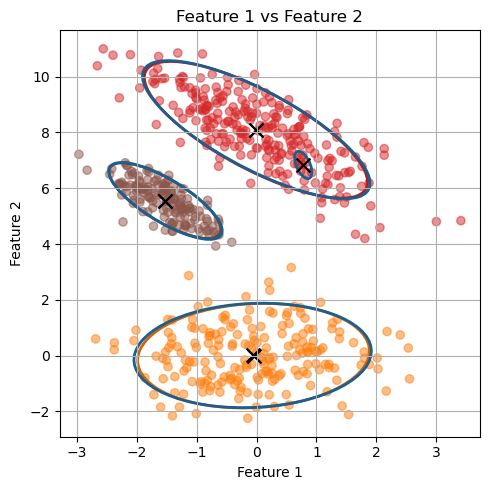

Timer unit: 1e-07 s

Total time: 2.15166 s
File: C:\Users\Miha\AppData\Local\Temp\ipykernel_3612\1933587708.py
Function: forward at line 55

Line #      Hits         Time  Per Hit   % Time  Line Contents
    55                                               @profile
    56                                               def forward(self, z, label = None):
    57                                                   
    58                                                   #z = z.to(self.device).to(dtype=torch.float32)
    59                                                   
    60                                                   # Update matching clusters
    61                                                   #self.matching_clusters = torch.where(self.cluster_labels[:self.c] == label)[0]
    62                                                   
    63                                                   # If label is None, treat as unsupervised clustering and match all clusters
    64      1

In [51]:

def process_sample_data():
    for z, label in zip(sample_data, sample_labels):
        model.forward(z, label)
        model.forward(z)
    plot_pairwise_against_first_feature(sample_data, sample_labels, model=model, num_sigma=num_sigma, N_max=2)   

process_sample_data()

%load_ext line_profiler
%lprun  -f model.forward \
-f model.merging_mech.compute_kappa_matrix \
-f model.merging_mech.compare_and_merge \
-f model.merging_mech.merging_mechanism \
-f model.merging_mech.compute_cluster_parameters \
-f model.merging_mech.plot_cluster \
-f model.merging_mech.perform_merge \
-f model.clustering.increment_or_add_cluster \
-f model.clustering._increment_cluster \
-f model.clustering._add_new_cluster \
-f model.math_ops._compute_covariance_inverse \
-f model.math_ops.compute_activation \
-f model.consequence.defuzzify\
process_sample_data()

In [52]:
feature_dim = 30  # or whatever the correct value is
N_max = 1 # Maximum number of clusters, provide an appropriate value
num_sigma = 3
kappa_join = 1.5 # Joining parameter, provide an appropriate value
S_0 = 1e-10 # Initial potential value, provide an appropriate value
c_max = 32
num_classes = 2
from sklearn.utils import shuffle

# Define the device
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")# Split the data into fraud and non-fraud

model = eGAUSSp(feature_dim=feature_dim, num_classes=num_classes, N_max=N_max, num_sigma=num_sigma, kappa_join=kappa_join, S_0=S_0, c_max=c_max, device=device)
model.overseer.toggle_debugging()

fraud_indices = data[data['Class'] == 1].index
non_fraud_indices = data[data['Class'] == 0].index

# Randomly select an equal number of non-fraud indices
random_non_fraud_indices = np.random.choice(non_fraud_indices, len(fraud_indices), replace=False)

# Concatenate fraud and non-fraud indices
subset_indices = np.concatenate([fraud_indices, random_non_fraud_indices])

# Shuffle the subset indices to mix fraud and non-fraud transactions
subset_indices = shuffle(subset_indices, random_state=42)

# Create the balanced subset
subset_data = data.loc[subset_indices]

# Now follow the same steps as before to create tensors and a DataLoader
features = subset_data.drop('Class', axis=1).values
labels = subset_data['Class'].values

# Convert features and labels to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(features_tensor, labels_tensor.unsqueeze(1)) # Unsqueezing to add the batch dimension
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True) # Shuffle for training

# Initialize the model (assuming 'eGAUSSp' is defined)
feature_dim = features.shape[1]  # Number of features



Debugging has been enabled.


In [53]:

# Splitting into features and labels
features = data.drop('Class', axis=1).values  # Assuming 'Class' is the label column
labels = data['Class'].values

# Converting to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.int64)

# Creating TensorDataset and DataLoader
dataset = TensorDataset(features_tensor, labels_tensor.unsqueeze(1))
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Adjust batch_size as needed

# Define the device
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")# Split the data into fraud and non-fraud


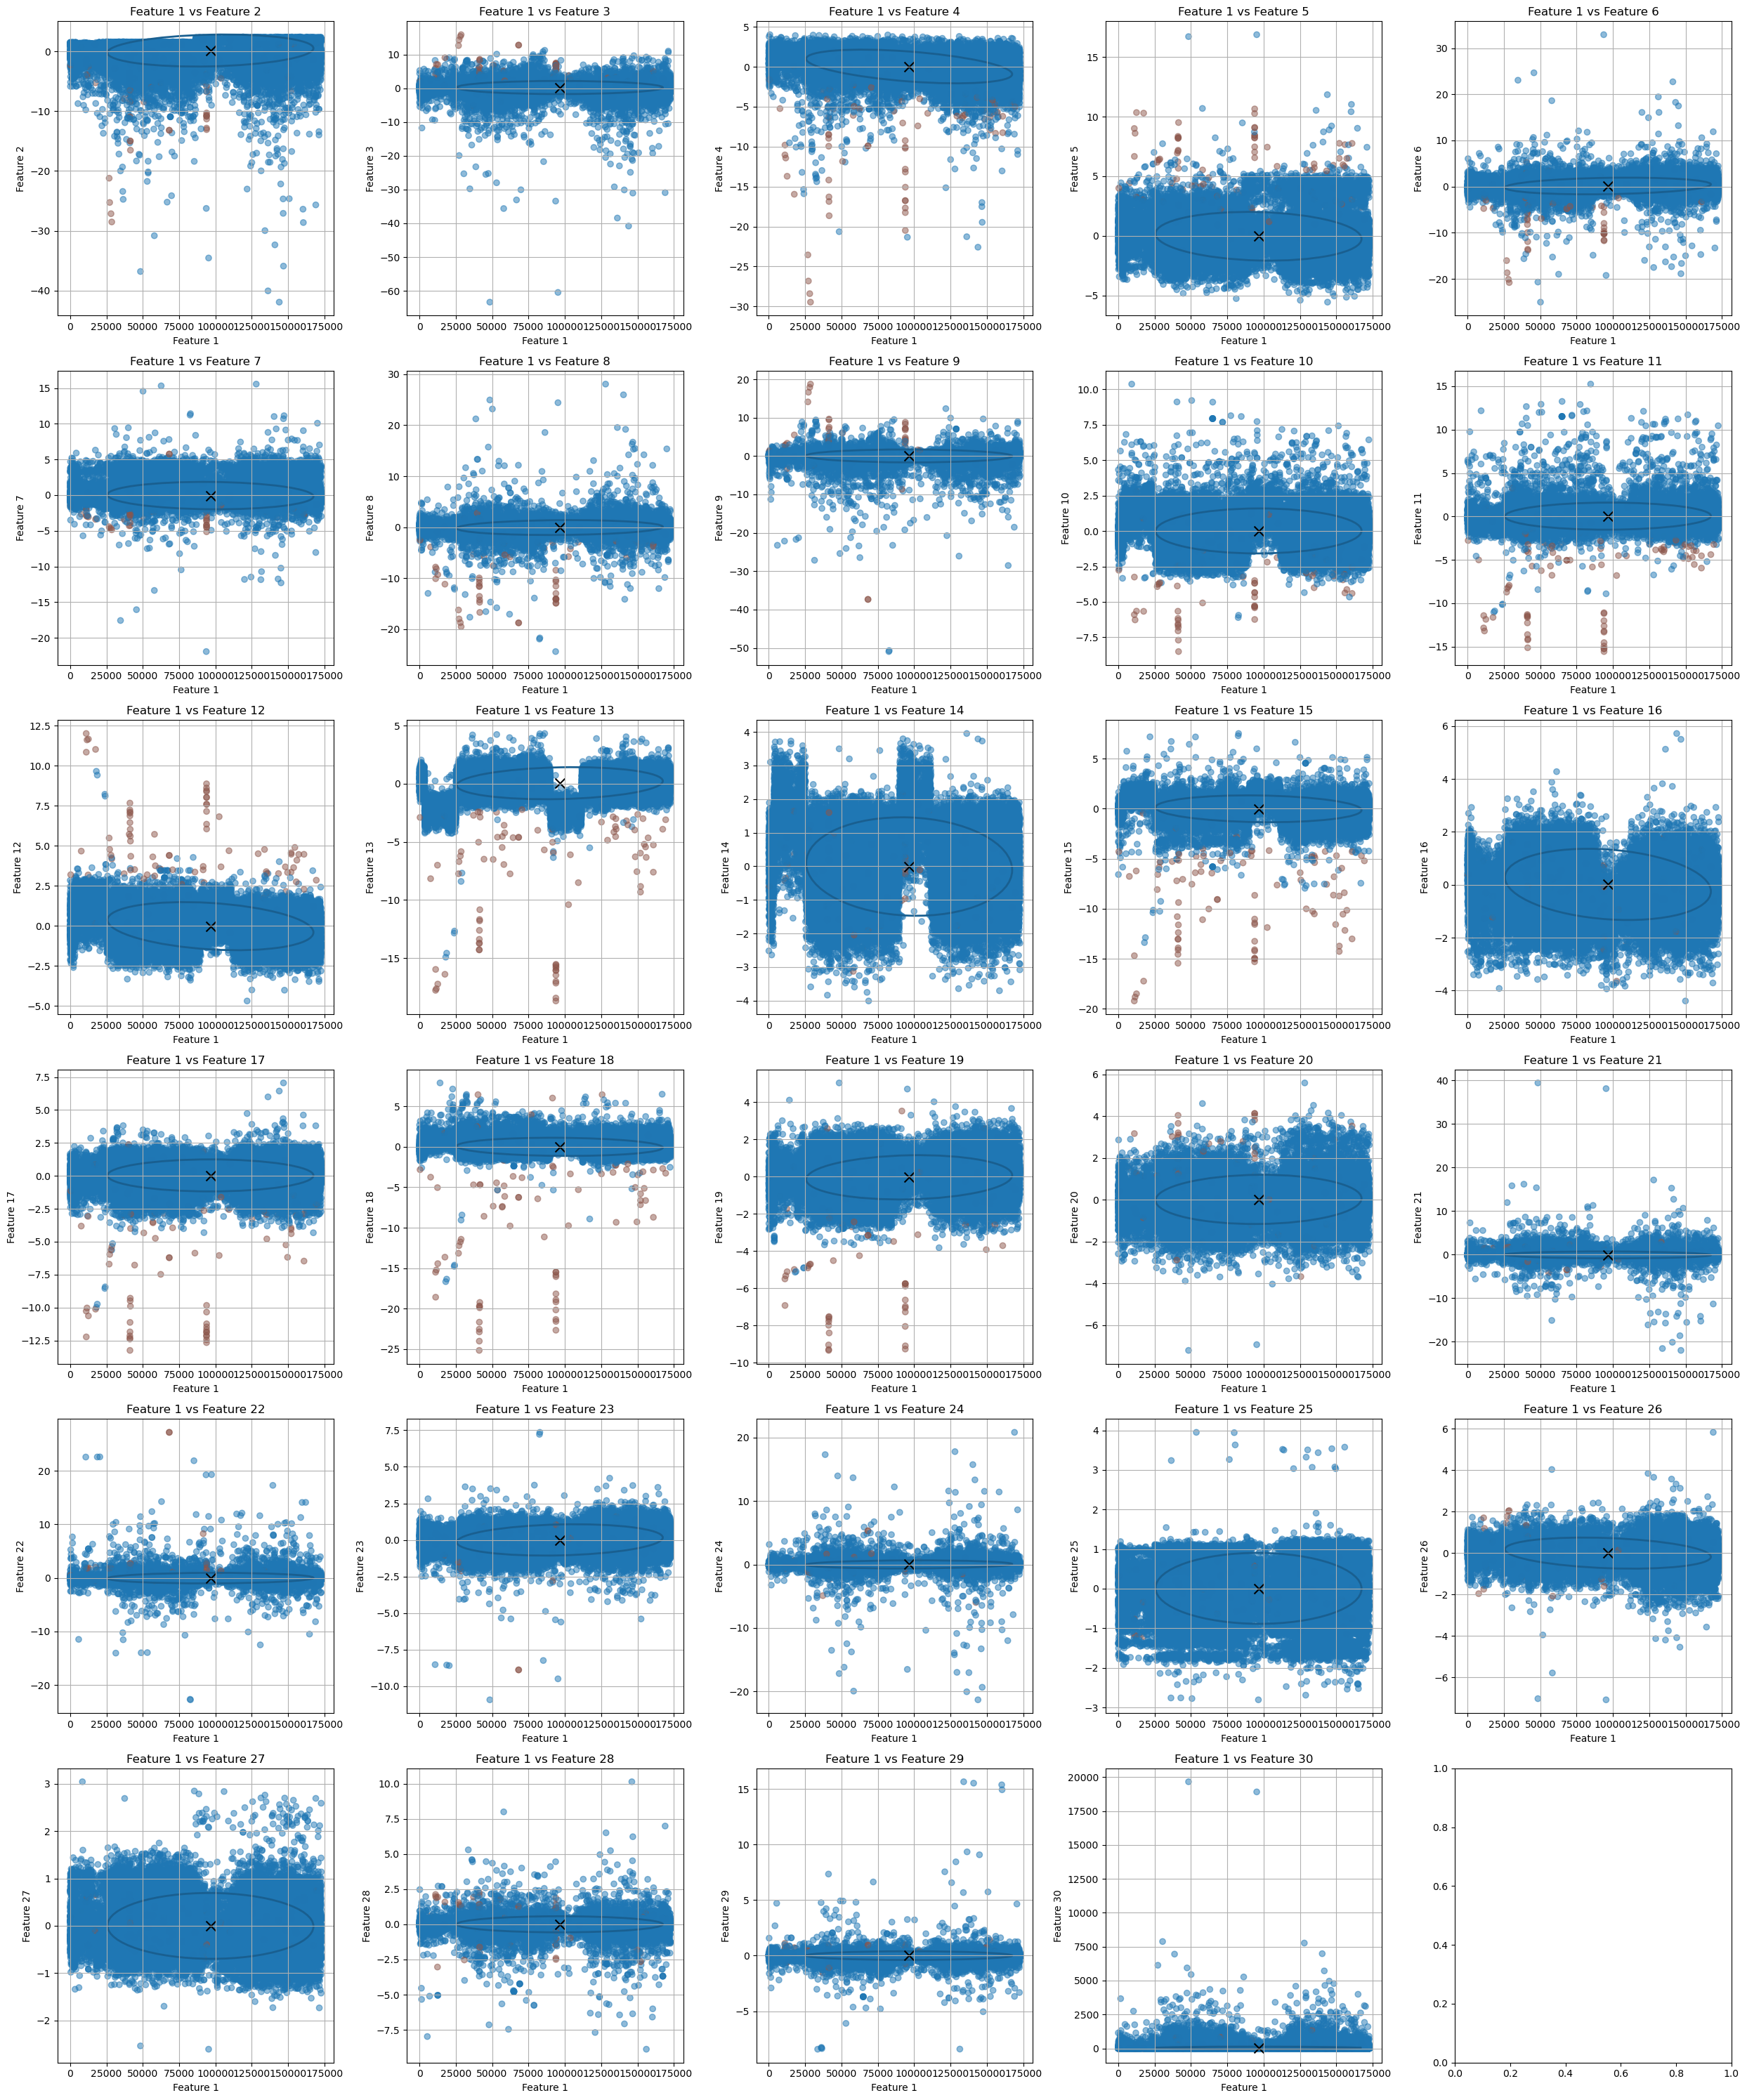

** Processed 53000 points. **
Number of clusters so far: 15484


In [54]:

def training_loop(dataloader, model):
    viewed_samples = []
    viewed_labels = []

    for idx, (point, label) in enumerate(dataloader):
        point, label = point.to(device).squeeze(0), label.to(device).squeeze(0)
        model(point, label)

        # Collect the viewed samples and labels
        viewed_samples.append(point)
        viewed_labels.append(label)

        if (idx + 1) % 1000 == 0:  # Plot every 100 samples
            
            print(f"** Processed {idx + 1} points. **")
            print(f"Number of clusters so far: {model.c}")

            # Convert the collected samples and labels to a NumPy array
            samples_np = torch.vstack(viewed_samples)
            labels_np = torch.vstack(viewed_labels).flatten()

            # Plot the samples
            plot_pairwise_against_first_feature(data=samples_np, labels=labels_np, model=model, num_sigma=num_sigma, N_max=feature_dim)


# Run the training loop
training_loop(dataloader, model)



In [ ]:
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Loss function (Cross-Entropy Loss for multi-class classification)
loss_function = torch.nn.CrossEntropyLoss()

def training_loop(model, dataloader, device):
    model.train()  # Set the model to training mode
    viewed_samples = []
    viewed_labels = []

    for idx, (point, label) in enumerate(dataloader):

        point, label = point.to(device).squeeze(0), label.to(device).squeeze(0)

        # Collect the viewed samples and labels
        viewed_samples.append(point)
        viewed_labels.append(label)

        optimizer.zero_grad()  # Zero the gradients

        # Inside your training loop:
        label_scores = model(point)

        # Assuming label_scores is a tensor or can be converted directly
        scores_tensor = label_scores.to(device).unsqueeze(0)

        # Calculate the loss using the scores tensor and the label
        loss = loss_function(scores_tensor, label)

        loss.backward()
        optimizer.step()

        if (idx + 1) % 100 == 0:
            print(f"** Processed {idx + 1} points. **")
            
            # Assuming a batch has been processed, evaluate on the batch
            '''
            with torch.no_grad():
                
                # During evaluation:
                # Convert logits to probabilities
                probs = torch.nn.functional.softmax(scores_tensor, dim=1)
                preds = torch.argmax(probs, dim=1).cpu().numpy()
                true_labels = label_tensor.cpu().numpy()

            unique_classes = len(np.unique(true_labels))
            if unique_classes > 1:
                # Calculate F1 and AUC because there is more than one class
                f1 = f1_score(true_labels, preds, average='weighted')
                auc = roc_auc_score(true_labels, probs[:, 1].cpu().numpy())
            else:
                # Only one unique class, metrics are not defined in this case
                f1 = float('nan')  # F1 is not applicable with a single class
                auc = float('nan')  # AUC is not applicable with a single class

            print(f"F1 Score: {f1 if not np.isnan(f1) else 'Undefined due to single class in labels'}, AUC: {auc if not np.isnan(auc) else 'Undefined due to single class in labels'}")
            '''
                        # Convert the collected samples and labels to a NumPy array
            samples_np = torch.vstack(viewed_samples)
            labels_np = torch.vstack(viewed_labels).flatten()

            # Plot the samples
            #plot_pairwise_against_first_feature(data=samples_np, labels=labels_np, model=model, num_sigma=num_sigma, N_max=1)

#Call the training loop
training_loop(model, dataloader, device)

In [ ]:
def evaluate_model_on_training_data(X, labels, model, device):
    model.eval()  # Set the model to evaluation mode
    # Assuming your model has a method to disable evolving, which is not present in standard PyTorch models.
    model.toggle_evolving(False)  # Turn off evolving
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():  # ensures we're not tracking gradients for updates
        for idx, (point, label) in enumerate(zip(X.values, labels)):
            point_tensor = torch.tensor(point, dtype=torch.float32).to(device)
            predicted_label,_ = model(point_tensor)  # no label provided during inference

            all_predictions.append(predicted_label.cpu().item())
            all_labels.append(label)  # No need to convert label to tensor
            
            if (idx + 1) % 100 == 0:
                print(f"** Processed {idx + 1} points. **")

    # Calculate accuracy
    accuracy = np.sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    print(f"Accuracy on training data: {accuracy*100:.2f}%")
    
    return accuracy

# Call the evaluate function with your data, labels, model, and device
accuracy = evaluate_model_on_training_data(X, labels, model, device)


In [ ]:
# Initialize counters
filtered_cluster_count = 0
filtered_cluster_samples = []

for idx in range(len(model.mu)):
    # Check if the cluster has more than N_max samples
    if model.n[idx] > N_max:
        filtered_cluster_count += 1
        filtered_cluster_samples.append(model.n[idx])

print(f"Number of clusters with more than {N_max} samples: {filtered_cluster_count}")
print(f"Sample counts for these clusters: {filtered_cluster_samples}")

In [ ]:
# Initialize a dictionary to store accumulated memberships for each cluster and label
accumulated_memberships = {cluster_idx: {label: 0 for label in np.unique(y.values)} for cluster_idx in range(model.c)}

# For each sample, compute its membership degree to each cluster and accumulate
for point, label in zip(X.values, y.values.ravel()):
    gamma = model.math_ops.compute_activation(torch.tensor(point).float())
    gamma_values = gamma.detach().numpy()
    
    for cluster_idx in range(model.c):
        accumulated_memberships[cluster_idx][label] += gamma_values[cluster_idx]

accumulated_memberships


In [ ]:
predicted_cluster_labels = {}

for cluster_idx, memberships in accumulated_memberships.items():
    predicted_cluster_labels[cluster_idx] = max(memberships, key=memberships.get)

predicted_cluster_labels
plot_pairwise_against_first_feature(X.values, labels, model=model, num_sigma=num_sigma, N_max=0)